<a href="https://colab.research.google.com/github/24215011123/Explainable-Ensemble-of-XGBoost-DeepMLP-and-TabTransformer-for-Heart-Disease-Prediction/blob/main/Neural_Embeddings_Neural_Models_(ANN_%26_DeepMLP_FT_Transformer_TabTransformer_(PyTorch)_Hybrid_Model_Neural_Embeddings_(MLP)_%2B_XGBoost_BRFSS_Heart_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neural Embeddings (MLP) with Focal Loss

Device: cuda

=== Training Neural Embeddings (MLP) ===
Epoch 1/20: train=0.0303 val=0.0324
Epoch 2/20: train=0.0295 val=0.0298
Epoch 3/20: train=0.0290 val=0.0308
Epoch 4/20: train=0.0286 val=0.0285
Epoch 5/20: train=0.0280 val=0.0299
Epoch 6/20: train=0.0275 val=0.0293
Epoch 7/20: train=0.0271 val=0.0303
Epoch 8/20: train=0.0267 val=0.0268
Epoch 9/20: train=0.0263 val=0.0283
Epoch 10/20: train=0.0260 val=0.0269
Epoch 11/20: train=0.0256 val=0.0332
Epoch 12/20: train=0.0252 val=0.0261
Epoch 13/20: train=0.0250 val=0.0276
Epoch 14/20: train=0.0247 val=0.0242
Epoch 15/20: train=0.0246 val=0.0249
Epoch 16/20: train=0.0244 val=0.0240
Epoch 17/20: train=0.0241 val=0.0245
Epoch 18/20: train=0.0238 val=0.0253
Epoch 19/20: train=0.0235 val=0.0245
Epoch 20/20: train=0.0232 val=0.0250


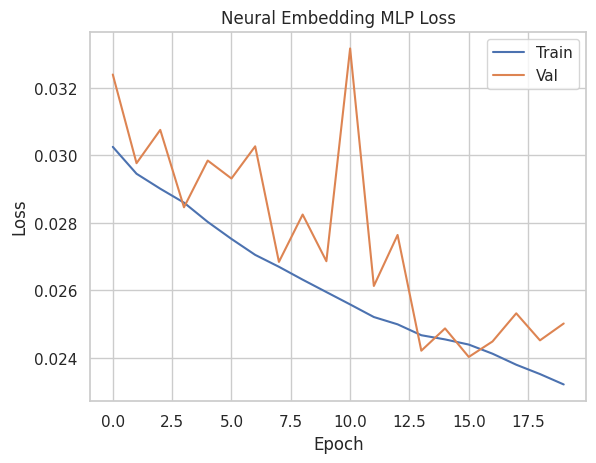

AUC=0.8288 AP=0.3371 Prec=0.2866 Rec=0.6300 F1=0.3940


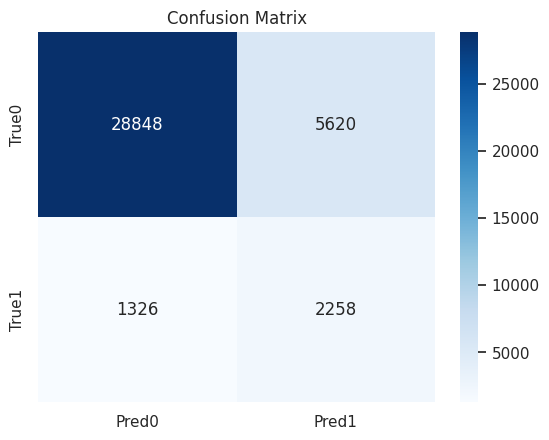

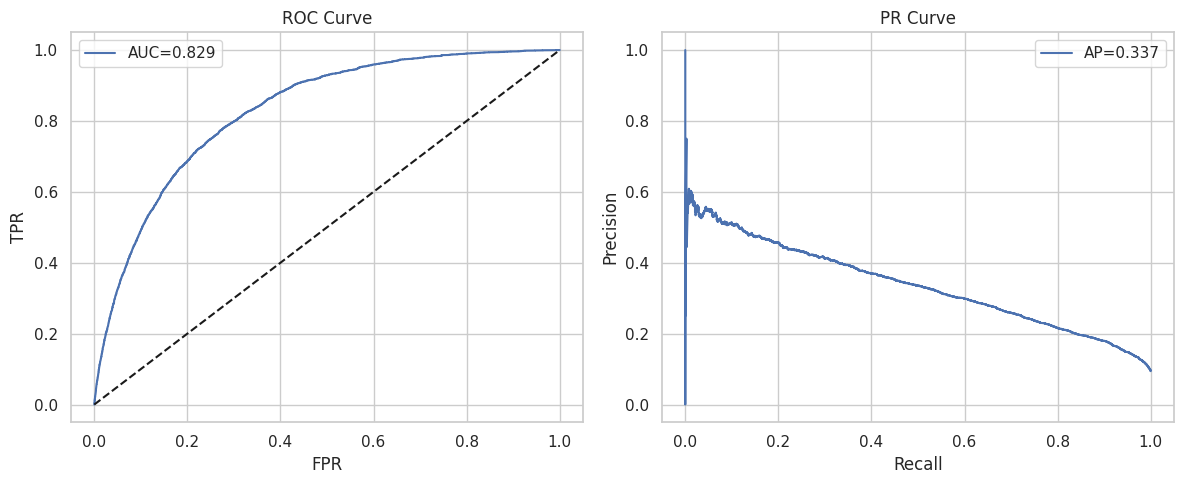

Final embeddings shape: (38052, 64)


In [11]:
# ======================================================
# Neural Embeddings (MLP) with Focal Loss
# ======================================================

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_score,
    recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------
# Dataset wrapper
# -------------------
class NumpyDataset(Dataset):
    def __init__(self, X_np, y_np):
        self.X = torch.tensor(X_np, dtype=torch.float32)
        self.y = torch.tensor(y_np.values if hasattr(y_np, "values") else y_np,
                              dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# -------------------
# Focal Loss
# -------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, logits, targets):
        bce = nn.BCEWithLogitsLoss(reduction="none")(logits, targets)
        probs = torch.sigmoid(logits)
        pt = torch.where(targets==1, probs, 1-probs)
        loss = self.alpha * (1-pt)**self.gamma * bce
        return loss.mean()

# -------------------
# Neural Embedding Model
# -------------------
class NeuralEmbeddingMLP(nn.Module):
    def __init__(self, input_dim, embed_dim=64, hidden=128, dropout=0.2):
        super().__init__()
        self.embedder = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.BatchNorm1d(hidden),
            nn.Dropout(dropout),
            nn.Linear(hidden, embed_dim),
            nn.ReLU()
        )
        self.classifier = nn.Linear(embed_dim, 1)  # final classification head

    def forward(self, x):
        emb = self.embedder(x)       # (batch, embed_dim)
        logits = self.classifier(emb)  # (batch, 1)
        return logits, emb

# -------------------
# Training Function
# -------------------
def train_neural_embedding(X_train, y_train, X_val, y_val,
                           epochs=20, batch_size=512, lr=1e-3, alpha=0.25, gamma=2.0):
    train_ds = NumpyDataset(X_train, y_train)
    val_ds   = NumpyDataset(X_val, y_val)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    model = NeuralEmbeddingMLP(input_dim=X_train.shape[1]).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = FocalLoss(alpha=alpha, gamma=gamma)

    best_state, best_val = None, float("inf")
    hist_train, hist_val = [], []

    for ep in range(epochs):
        # train
        model.train(); tot=0
        for xb,yb in train_loader:
            xb,yb=xb.to(device), yb.to(device)
            opt.zero_grad()
            logits,_=model(xb)
            loss=loss_fn(logits,yb)
            loss.backward(); opt.step()
            tot+=loss.item()
        train_loss=tot/len(train_loader)

        # validation
        model.eval(); vtot=0
        with torch.no_grad():
            for xb,yb in val_loader:
                xb,yb=xb.to(device), yb.to(device)
                logits,_=model(xb)
                vtot+=loss_fn(logits,yb).item()
        val_loss=vtot/len(val_loader)

        hist_train.append(train_loss); hist_val.append(val_loss)
        print(f"Epoch {ep+1}/{epochs}: train={train_loss:.4f} val={val_loss:.4f}")
        if val_loss<best_val:
            best_val=val_loss; best_state={k:v.cpu() for k,v in model.state_dict().items()}

    if best_state: model.load_state_dict(best_state)

    # plot loss curve
    plt.plot(hist_train,label="Train"); plt.plot(hist_val,label="Val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Neural Embedding MLP Loss"); plt.legend(); plt.show()
    return model

# -------------------
# Evaluation Function
# -------------------
def evaluate_embedding_model(model, X_test, y_test, thr=0.5):
    model.eval()
    with torch.no_grad():
        logits, embeddings = model(torch.tensor(X_test, dtype=torch.float32).to(device))
        probs = torch.sigmoid(logits).cpu().numpy().flatten()
        embs  = embeddings.cpu().numpy()
    preds = (probs>=thr).astype(int)

    auc = roc_auc_score(y_test, probs)
    ap  = average_precision_score(y_test, probs)
    prec= precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds, zero_division=0)
    f1  = f1_score(y_test, preds, zero_division=0)

    print(f"AUC={auc:.4f} AP={ap:.4f} Prec={prec:.4f} Rec={rec:.4f} F1={f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred0","Pred1"], yticklabels=["True0","True1"])
    plt.title("Confusion Matrix"); plt.show()

    # ROC & PR curves
    fpr, tpr, _ = roc_curve(y_test, probs)
    prec_c, rec_c, _ = precision_recall_curve(y_test, probs)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(fpr,tpr,label=f"AUC={auc:.3f}"); plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend()
    plt.subplot(1,2,2); plt.plot(rec_c,prec_c,label=f"AP={ap:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve"); plt.legend()
    plt.tight_layout(); plt.show()

    return probs, preds, embs

# -------------------
# Run Model
# -------------------
print("\n=== Training Neural Embeddings (MLP) ===")
neural_emb = train_neural_embedding(X_train_res, y_train_res, X_val, y_val,
                                    epochs=20, batch_size=512, lr=1e-3)

probs_emb, preds_emb, embeddings = evaluate_embedding_model(neural_emb, X_test, y_test)
print("Final embeddings shape:", embeddings.shape)


Running t-SNE...


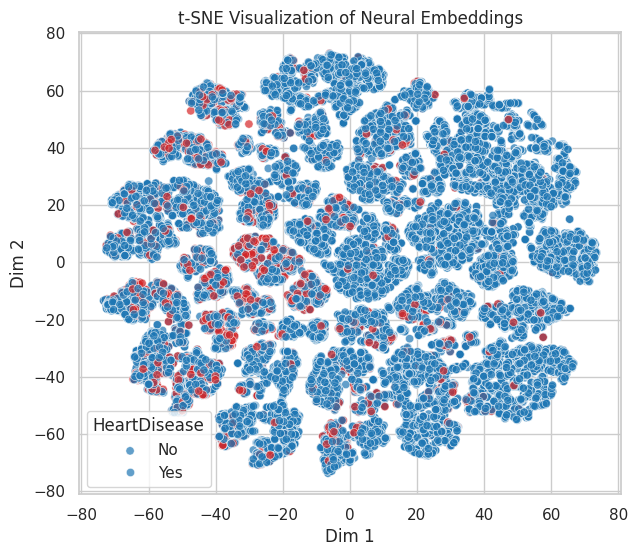

Running UMAP...


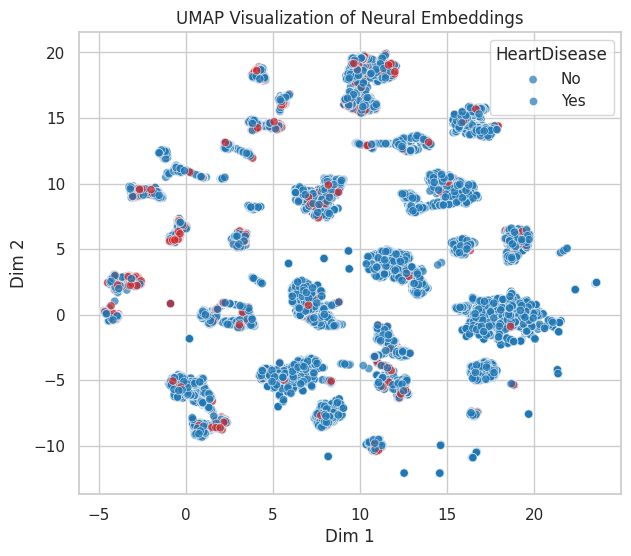

In [12]:
# ======================================================
# Visualization of Neural Embeddings using t-SNE and UMAP
# ======================================================
!pip install -q umap-learn

from sklearn.manifold import TSNE
import umap.umap_ as umap

# y_test should already be defined (labels of test set)
labels = y_test.values if hasattr(y_test, "values") else y_test

# -------------------
# t-SNE visualization
# -------------------
print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
emb_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(7,6))
sns.scatterplot(x=emb_tsne[:,0], y=emb_tsne[:,1], hue=labels,
                palette=["#1f77b4","#d62728"], alpha=0.7)
plt.title("t-SNE Visualization of Neural Embeddings")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.legend(title="HeartDisease", labels=["No","Yes"])
plt.show()

# -------------------
# UMAP visualization
# -------------------
print("Running UMAP...")
um = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
emb_umap = um.fit_transform(embeddings)

plt.figure(figsize=(7,6))
sns.scatterplot(x=emb_umap[:,0], y=emb_umap[:,1], hue=labels,
                palette=["#1f77b4","#d62728"], alpha=0.7)
plt.title("UMAP Visualization of Neural Embeddings")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.legend(title="HeartDisease", labels=["No","Yes"])
plt.show()


Neural Models (ANN & DeepMLP) with Focal Loss

Device: cuda

=== Training ANN with Focal Loss ===
Epoch 1/20 train=0.0316 val=0.0292
Epoch 2/20 train=0.0300 val=0.0320
Epoch 3/20 train=0.0298 val=0.0302
Epoch 4/20 train=0.0296 val=0.0298
Epoch 5/20 train=0.0294 val=0.0313
Epoch 6/20 train=0.0293 val=0.0321
Epoch 7/20 train=0.0291 val=0.0291
Epoch 8/20 train=0.0288 val=0.0290
Epoch 9/20 train=0.0285 val=0.0326
Epoch 10/20 train=0.0281 val=0.0302
Epoch 11/20 train=0.0277 val=0.0299
Epoch 12/20 train=0.0274 val=0.0285
Epoch 13/20 train=0.0272 val=0.0278
Epoch 14/20 train=0.0269 val=0.0252
Epoch 15/20 train=0.0267 val=0.0298
Epoch 16/20 train=0.0265 val=0.0295
Epoch 17/20 train=0.0263 val=0.0292
Epoch 18/20 train=0.0261 val=0.0257
Epoch 19/20 train=0.0259 val=0.0259
Epoch 20/20 train=0.0257 val=0.0271


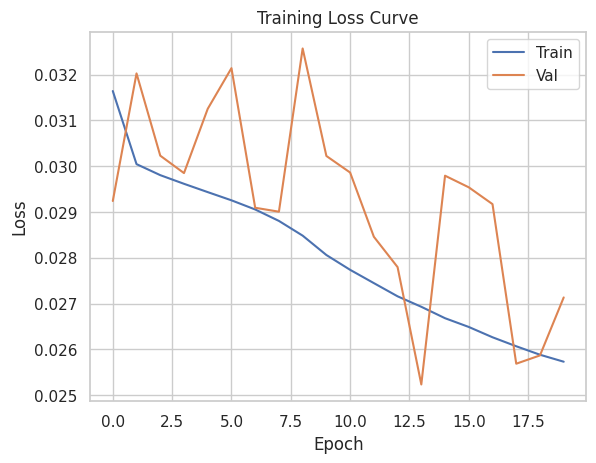

AUC=0.8408 AP=0.3492 Prec=0.2857 Rec=0.6738 F1=0.4012


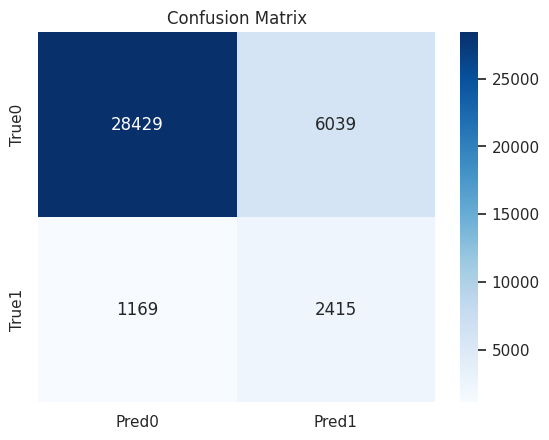

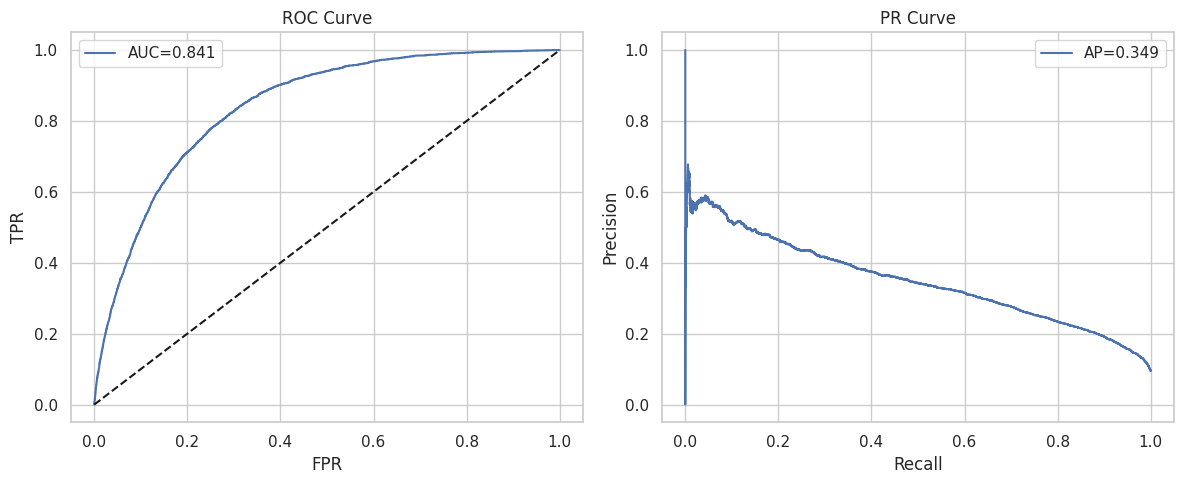


=== Training DeepMLP with Focal Loss ===
Epoch 1/30 train=0.0306 val=0.0312
Epoch 2/30 train=0.0297 val=0.0321
Epoch 3/30 train=0.0293 val=0.0298
Epoch 4/30 train=0.0288 val=0.0290
Epoch 5/30 train=0.0282 val=0.0295
Epoch 6/30 train=0.0276 val=0.0276
Epoch 7/30 train=0.0269 val=0.0270
Epoch 8/30 train=0.0265 val=0.0257
Epoch 9/30 train=0.0260 val=0.0274
Epoch 10/30 train=0.0255 val=0.0256
Epoch 11/30 train=0.0252 val=0.0241
Epoch 12/30 train=0.0249 val=0.0258
Epoch 13/30 train=0.0247 val=0.0261
Epoch 14/30 train=0.0244 val=0.0248
Epoch 15/30 train=0.0244 val=0.0228
Epoch 16/30 train=0.0240 val=0.0234
Epoch 17/30 train=0.0238 val=0.0232
Epoch 18/30 train=0.0237 val=0.0240
Epoch 19/30 train=0.0236 val=0.0238
Epoch 20/30 train=0.0236 val=0.0250
Epoch 21/30 train=0.0237 val=0.0237
Epoch 22/30 train=0.0233 val=0.0241
Epoch 23/30 train=0.0231 val=0.0229
Epoch 24/30 train=0.0229 val=0.0224
Epoch 25/30 train=0.0228 val=0.0256
Epoch 26/30 train=0.0226 val=0.0234
Epoch 27/30 train=0.0225 val=0.

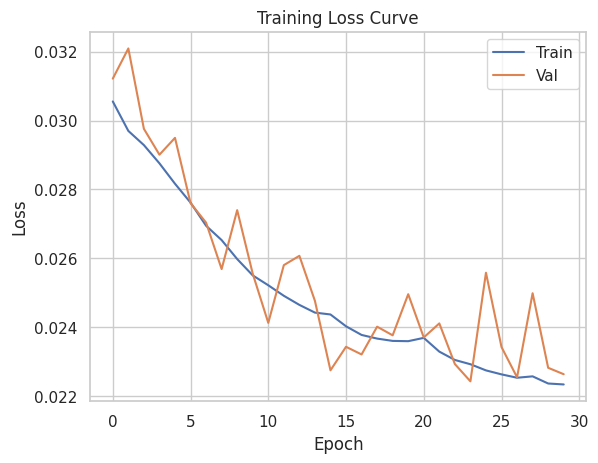

AUC=0.8301 AP=0.3362 Prec=0.2980 Rec=0.5968 F1=0.3975


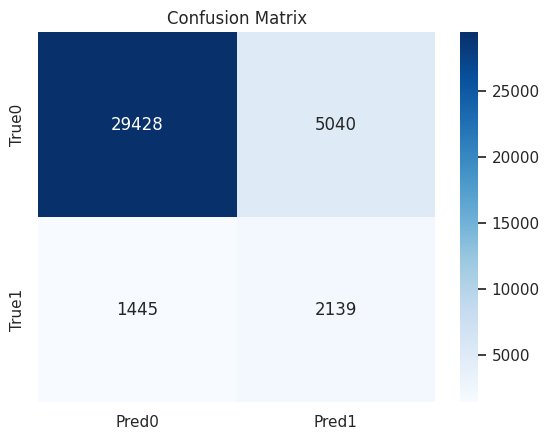

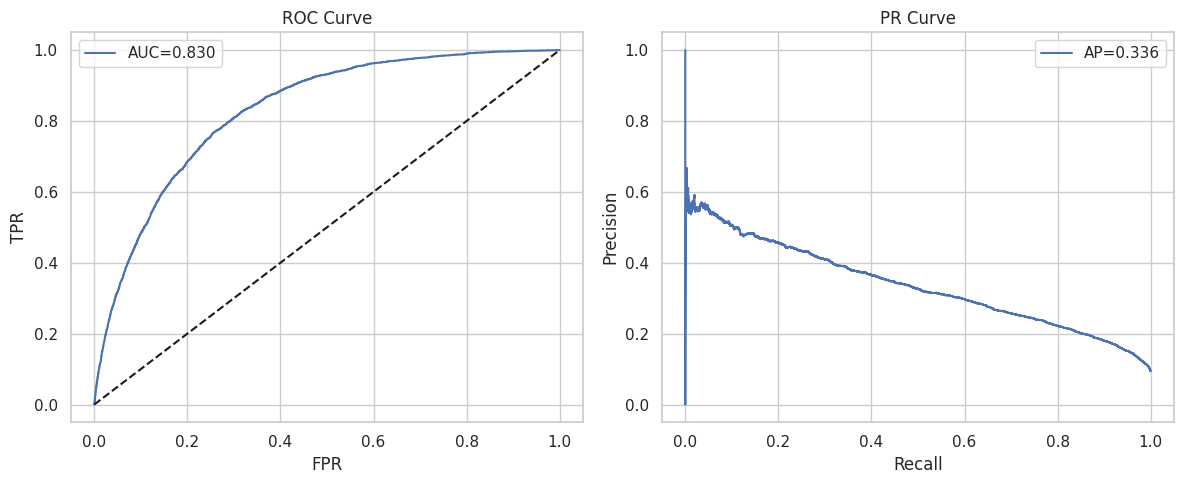

In [10]:
# ======================================================
# Neural Models (ANN & DeepMLP) with Focal Loss
# ======================================================

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_score,
    recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------
# Dataset wrapper
# -------------------
class NumpyDataset(Dataset):
    def __init__(self, X_np, y_np):
        self.X = torch.tensor(X_np, dtype=torch.float32)
        self.y = torch.tensor(y_np.values if hasattr(y_np, "values") else y_np,
                              dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# -------------------
# Focal Loss
# -------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, logits, targets):
        bce = nn.BCEWithLogitsLoss(reduction="none")(logits, targets)
        probs = torch.sigmoid(logits)
        pt = torch.where(targets==1, probs, 1-probs)
        loss = self.alpha * (1-pt)**self.gamma * bce
        return loss.mean()

# -------------------
# Models
# -------------------
class ANN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x): return self.net(x)

class DeepMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256), nn.ReLU(), nn.BatchNorm1d(256), nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(), nn.BatchNorm1d(128), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.ReLU(), nn.BatchNorm1d(64), nn.Dropout(0.2),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x): return self.net(x)

# -------------------
# Training Loop
# -------------------
def train_model(model, train_ds, val_ds, epochs=20, batch_size=512, lr=1e-3, alpha=0.25, gamma=2.0):
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = FocalLoss(alpha=alpha, gamma=gamma)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    best_state, best_val = None, float("inf")
    train_hist, val_hist = [], []

    for ep in range(epochs):
        model.train(); tot=0
        for xb,yb in train_loader:
            xb,yb=xb.to(device), yb.to(device)
            opt.zero_grad()
            logits=model(xb)
            loss=loss_fn(logits,yb)
            loss.backward(); opt.step()
            tot+=loss.item()
        train_loss=tot/len(train_loader)

        model.eval(); vtot=0
        with torch.no_grad():
            for xb,yb in val_loader:
                xb,yb=xb.to(device), yb.to(device)
                logits=model(xb)
                vtot+=loss_fn(logits,yb).item()
        val_loss=vtot/len(val_loader)

        train_hist.append(train_loss); val_hist.append(val_loss)
        print(f"Epoch {ep+1}/{epochs} train={train_loss:.4f} val={val_loss:.4f}")
        if val_loss<best_val:
            best_val=val_loss; best_state={k:v.cpu() for k,v in model.state_dict().items()}

    if best_state: model.load_state_dict(best_state)

    plt.plot(train_hist,label="Train"); plt.plot(val_hist,label="Val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss Curve"); plt.legend(); plt.show()
    return model

# -------------------
# Evaluation
# -------------------
def evaluate_model(model, X_test, y_test, thr=0.5):
    model.eval()
    with torch.no_grad():
        probs = torch.sigmoid(model(torch.tensor(X_test, dtype=torch.float32).to(device))).cpu().numpy().flatten()
    preds = (probs>=thr).astype(int)

    auc = roc_auc_score(y_test, probs)
    ap  = average_precision_score(y_test, probs)
    prec= precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds, zero_division=0)
    f1  = f1_score(y_test, preds, zero_division=0)

    print(f"AUC={auc:.4f} AP={ap:.4f} Prec={prec:.4f} Rec={rec:.4f} F1={f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred0","Pred1"], yticklabels=["True0","True1"])
    plt.title("Confusion Matrix"); plt.show()

    # ROC & PR curves
    fpr, tpr, _ = roc_curve(y_test, probs)
    prec_c, rec_c, _ = precision_recall_curve(y_test, probs)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(fpr,tpr,label=f"AUC={auc:.3f}"); plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend()
    plt.subplot(1,2,2); plt.plot(rec_c,prec_c,label=f"AP={ap:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve"); plt.legend()
    plt.tight_layout(); plt.show()

    return probs, preds

# -------------------
# Run ANN
# -------------------
train_ds = NumpyDataset(X_train_res, y_train_res)
val_ds   = NumpyDataset(X_val, y_val)

print("\n=== Training ANN with Focal Loss ===")
ann = ANN(input_dim=X_train_res.shape[1])
ann = train_model(ann, train_ds, val_ds, epochs=20)
probs_ann, preds_ann = evaluate_model(ann, X_test, y_test)

# -------------------
# Run DeepMLP
# -------------------
print("\n=== Training DeepMLP with Focal Loss ===")
deepmlp = DeepMLP(input_dim=X_train_res.shape[1])
deepmlp = train_model(deepmlp, train_ds, val_ds, epochs=30)
probs_dmlp, preds_dmlp = evaluate_model(deepmlp, X_test, y_test)


# FT-Transformer on BRFSS Heart Disease Dataset

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using device: cuda
Full dataset size: (128681, 22)
[LightGBM] [Info] Number of positive: 81653, number of negative: 81653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 163306, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Top features: ['Smoker', 'HighBP', 'GenHlth', 'CholCheck', 'Age', 'Income', 'HighChol', 'Education', 'Diabetes', 'Veggies', 'PhysHlth', 'Stroke', 'Fruits', 'AnyHealthcare', 'DiffWalk']
Shape after feature selection: (163306, 15)
[FT] Epoch 1, loss=0.4165
[FT] Epoch 2, loss=0.3644
[FT] Epoch 3, loss=0.3669
[FT

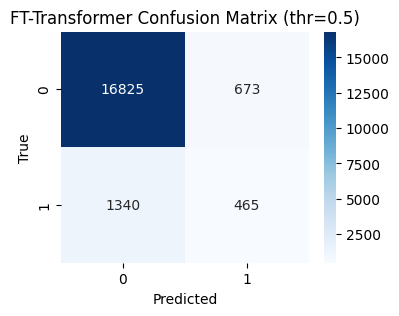

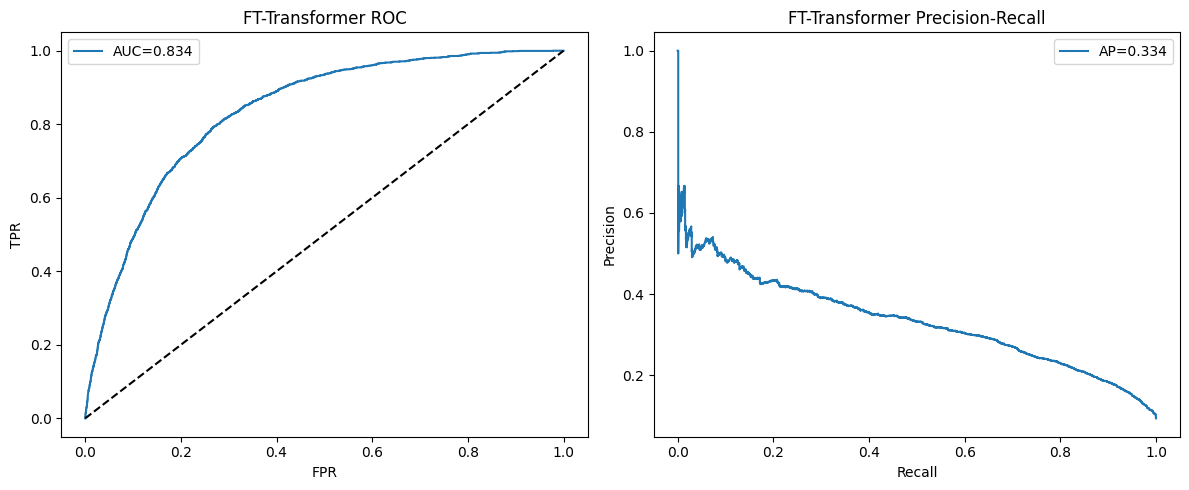

In [2]:
# ======================================================
# FT-Transformer on BRFSS Heart Disease Dataset
# ======================================================

!pip install -q git+https://github.com/Yura52/rtdl.git torch-optimizer imbalanced-learn lightgbm shap xgboost

import os, random, warnings
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, roc_curve, precision_recall_curve,
    confusion_matrix
)
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import rtdl

# -------------------
# Reproducibility
# -------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------
# Load Dataset
# -------------------
DATA_PATH = "/content/heart_disease_health_indicators_BRFSS2015.csv"
df = pd.read_csv(DATA_PATH)
print("Full dataset size:", df.shape)

binary_cols = ["HighBP","HighChol","CholCheck","Smoker","Stroke","Diabetes",
               "PhysActivity","Fruits","Veggies","HvyAlcoholConsump",
               "AnyHealthcare","NoDocbcCost","DiffWalk","Sex"]
numeric_cols = ["BMI","MentHlth","PhysHlth","Age"]
categorical_cols = ["GenHlth","Education","Income"]
FEAT_NAMES = binary_cols + numeric_cols + categorical_cols
TARGET = "HeartDiseaseorAttack"

X = df[FEAT_NAMES]
y = df[TARGET].astype(int)

# -------------------
# Preprocessing
# -------------------
num_trans = Pipeline([("imp",SimpleImputer(strategy="median")),("scaler",StandardScaler())])
cat_trans = Pipeline([("imp",SimpleImputer(strategy="most_frequent"))])
preproc = ColumnTransformer([
    ("num", num_trans, numeric_cols),
    ("cat", cat_trans, binary_cols+categorical_cols)
])
preproc.fit(X)

X_all = preproc.transform(X)
if hasattr(X_all,"toarray"):
    X_all = X_all.toarray()

# -------------------
# Split Train/Val/Test
# -------------------
X_train_raw, X_temp, y_train, y_temp = train_test_split(X_all, y, test_size=0.3, stratify=y, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

# Balance training data
sm = SMOTE(random_state=SEED)
X_train_res, y_train_res = sm.fit_resample(X_train_raw, y_train)

# -------------------
# Feature Selection (LightGBM importance)
# -------------------
lgb_model = lgb.LGBMClassifier(random_state=SEED, n_jobs=-1)
lgb_model.fit(X_train_res, y_train_res)

feat_imp = pd.Series(lgb_model.feature_importances_, index=FEAT_NAMES).sort_values(ascending=False)
top_feats = feat_imp.head(15).index.tolist()
print("Top features:", top_feats)

feat_idx = [FEAT_NAMES.index(f) for f in top_feats]
X_train_res = X_train_res[:, feat_idx]
X_val       = X_val[:, feat_idx]
X_test      = X_test[:, feat_idx]

print("Shape after feature selection:", X_train_res.shape)

# -------------------
# Convert to Torch
# -------------------
X_train_t = torch.tensor(X_train_res, dtype=torch.float32)
y_train_t = torch.tensor(y_train_res.values, dtype=torch.long)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val.values, dtype=torch.long)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values, dtype=torch.long)

# -------------------
# FT-Transformer Model
# -------------------
ft = rtdl.FTTransformer.make_default(
    n_num_features=X_train_res.shape[1],
    cat_cardinalities=None,
    d_out=2
).to(device)

opt = torch.optim.AdamW(ft.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=512, shuffle=True)

# -------------------
# Training Loop
# -------------------
for epoch in range(80):  # increase to 50 for stronger results
    ft.train(); total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out = ft(xb, None)   # ✅ pass None for categorical
        loss = loss_fn(out, yb)
        loss.backward()
        opt.step()
        total_loss += loss.item()
    print(f"[FT] Epoch {epoch+1}, loss={total_loss/len(train_loader):.4f}")

# -------------------
# Evaluation
# -------------------
ft.eval()
with torch.no_grad():
    probs_ft = ft(X_test_t.to(device), None).softmax(1)[:,1].cpu().numpy()

preds_ft = (probs_ft >= 0.5).astype(int)

auc = roc_auc_score(y_test, probs_ft)
ap = average_precision_score(y_test, probs_ft)
prec = precision_score(y_test, preds_ft, zero_division=0)
rec = recall_score(y_test, preds_ft, zero_division=0)
f1 = f1_score(y_test, preds_ft, zero_division=0)

print("\n===== FT-Transformer Results =====")
print(f"AUC: {auc:.4f}")
print(f"AP : {ap:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, preds_ft)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("FT-Transformer Confusion Matrix (thr=0.5)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# ROC + PR curves
fpr, tpr, _ = roc_curve(y_test, probs_ft)
prec_curve, rec_curve, _ = precision_recall_curve(y_test, probs_ft)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.title("FT-Transformer ROC"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()

plt.subplot(1,2,2)
plt.plot(rec_curve, prec_curve, label=f"AP={ap:.3f}")
plt.title("FT-Transformer Precision-Recall"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
plt.tight_layout(); plt.show()


TabTransformer (PyTorch)


=== Training TabTransformer (PyTorch) ===
Epoch 1/20 | train_loss=0.0308 | val_loss=0.0275
Epoch 2/20 | train_loss=0.0282 | val_loss=0.0285
Epoch 3/20 | train_loss=0.0250 | val_loss=0.0236
Epoch 4/20 | train_loss=0.0228 | val_loss=0.0252
Epoch 5/20 | train_loss=0.0215 | val_loss=0.0243
Epoch 6/20 | train_loss=0.0210 | val_loss=0.0224
Epoch 7/20 | train_loss=0.0206 | val_loss=0.0272
Epoch 8/20 | train_loss=0.0203 | val_loss=0.0202
Epoch 9/20 | train_loss=0.0198 | val_loss=0.0211
Epoch 10/20 | train_loss=0.0196 | val_loss=0.0232
Epoch 11/20 | train_loss=0.0194 | val_loss=0.0221
Epoch 12/20 | train_loss=0.0194 | val_loss=0.0196
Epoch 13/20 | train_loss=0.0194 | val_loss=0.0197
Epoch 14/20 | train_loss=0.0192 | val_loss=0.0277
Epoch 15/20 | train_loss=0.0192 | val_loss=0.0185
Epoch 16/20 | train_loss=0.0190 | val_loss=0.0232
Epoch 17/20 | train_loss=0.0190 | val_loss=0.0206
Epoch 18/20 | train_loss=0.0188 | val_loss=0.0203
Epoch 19/20 | train_loss=0.0189 | val_loss=0.0189
Epoch 20/20 | tr

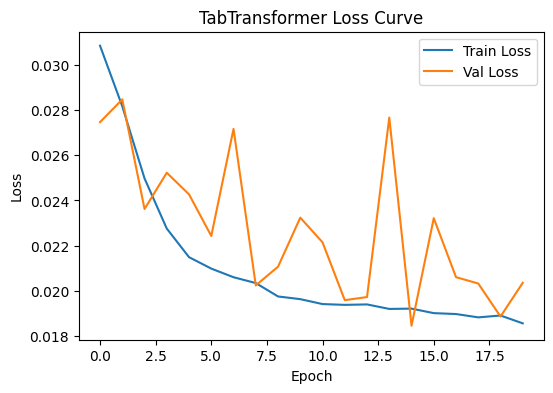


=== TabTransformer (Baseline @0.5) ===
              Value
AUC        0.824942
AP         0.316786
Precision  0.353319
Recall     0.365651
F1         0.359379

=== TabTransformer (Optimized @ 0.452) ===
              Value
AUC        0.824942
AP         0.316786
Precision  0.307550
Recall     0.550693
F1         0.394679


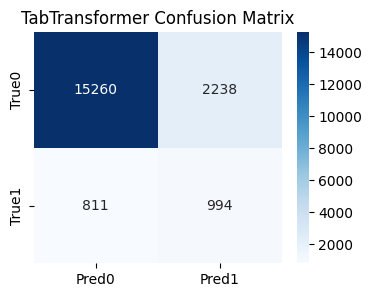

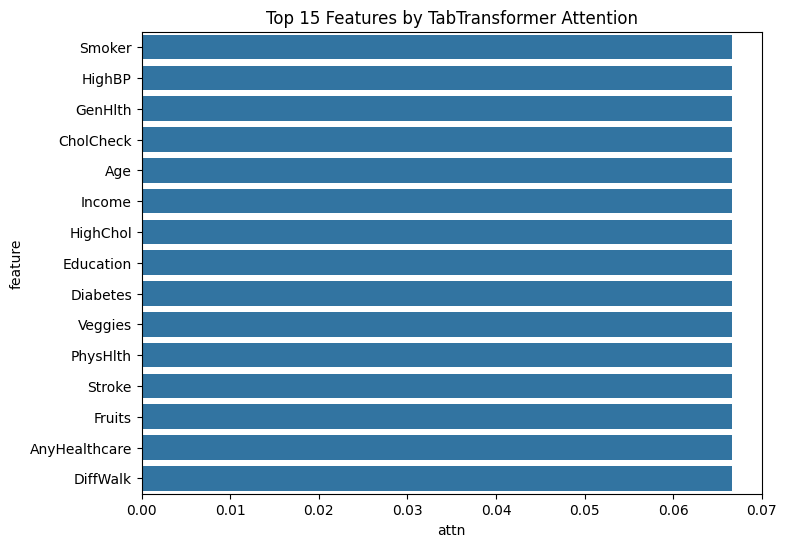


===== TabTransformer Evaluation =====
probs_train shape: (19303,)
probs_test shape: (19303,)
labels_train shape: (19303,)
labels_test shape: (19303,)


In [7]:
#Step 9.1 — Dataset + Model Setup

import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, roc_curve, precision_recall_curve,
    confusion_matrix
)


print("\n=== Training TabTransformer (PyTorch) ===")

class TabDatasetTorch(Dataset):
    def __init__(self, X_np, y_np):
        # Explicitly convert y_np to a NumPy array if it's a pandas Series
        if isinstance(y_np, pd.Series):
            y_np = y_np.values
        self.X = torch.tensor(X_np, dtype=torch.float32)
        self.y = torch.tensor(y_np, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

class TabTransformerTorch(nn.Module):
    def __init__(self, input_dim, emb_dim=16, n_heads=2, mlp_hidden=64, dropout=0.1):
        super().__init__()
        self.proj = nn.Linear(1, emb_dim)
        self.mha = nn.MultiheadAttention(embed_dim=emb_dim, num_heads=n_heads, batch_first=True)
        self.ff = nn.Sequential(nn.Linear(emb_dim, emb_dim), nn.ReLU())
        self.classifier = nn.Sequential(
            nn.Linear(input_dim*emb_dim, mlp_hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(mlp_hidden, 1)
        )
    def forward(self, x):
        b,f = x.shape
        x = x.unsqueeze(-1)   # (b,f,1)
        emb = self.proj(x)    # (b,f,emb_dim)
        attn_out, attn_weights = self.mha(emb, emb, emb, need_weights=True, average_attn_weights=False)
        out = self.ff(emb + attn_out)
        flat = out.reshape(b, -1)
        logits = self.classifier(flat)
        return logits, attn_weights, out


#Step 9.2 — Focal Loss & Training Loop

class FocalLossTorch(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, logits, targets):
        bce = nn.BCEWithLogitsLoss(reduction='none')(logits, targets)
        probs = torch.sigmoid(logits)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal = self.alpha * (1 - pt) ** self.gamma * bce
        return focal.mean()

# Placeholder for compute_metrics
def compute_metrics(y_true, y_pred_proba, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)
    auc = roc_auc_score(y_true, y_pred_proba)
    ap = average_precision_score(y_true, y_pred_proba)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return {"AUC": auc, "AP": ap, "Precision": prec, "Recall": rec, "F1": f1}

# Placeholder for find_best_threshold
def find_best_threshold(y_true, y_pred_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8) # Add epsilon for stability
    best_f1 = np.max(f1_scores)
    best_threshold = thresholds[np.argmax(f1_scores)]
    return best_threshold, best_f1


def train_tabtransformer(X_train_res, y_train_res, X_val, y_val, X_test, y_test,
                         n_epochs=20, batch_size=512, use_focal=True, device=None):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = TabTransformerTorch(input_dim=X_train_res.shape[1]).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = FocalLossTorch(alpha=0.25, gamma=2.0) if use_focal else nn.BCEWithLogitsLoss()

    # Convert y data to NumPy arrays before creating Datasets
    y_train_res_np = y_train_res.values if isinstance(y_train_res, pd.Series) else y_train_res
    y_val_np = y_val.values if isinstance(y_val, pd.Series) else y_val
    y_test_np = y_test.values if isinstance(y_test, pd.Series) else y_test


    train_loader = DataLoader(TabDatasetTorch(X_train_res, y_train_res_np), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TabDatasetTorch(X_val, y_val_np), batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(TabDatasetTorch(X_test, y_test_np), batch_size=batch_size, shuffle=False)

    train_losses, val_losses = [], []
    best_val_loss = np.inf; best_state = None

    for epoch in range(n_epochs):
        model.train(); total_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits, _, _ = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward(); opt.step()
            total_loss += loss.item()
        train_loss = total_loss/len(train_loader)

        # validation
        model.eval(); val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits, _, _ = model(xb)
                val_loss += loss_fn(logits,yb).item()
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{n_epochs} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}

    if best_state: model.load_state_dict(best_state)

    # Plot loss curve inline
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("TabTransformer Loss Curve")
    plt.legend(); plt.show()

    # Test inference
    model.eval(); all_probs, all_labels, attn_maps = [], [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits, attn_weights, _ = model(xb)
            probs = torch.sigmoid(logits).cpu().numpy().flatten()
            all_probs.append(probs)
            all_labels.append(yb.numpy().flatten())
            attn_np = attn_weights.cpu().numpy()
            if attn_np.ndim == 4: attn_feat = attn_np.mean(axis=(0,1,3))
            elif attn_np.ndim == 3: attn_feat = attn_np.mean(axis=(0,2))
            else: attn_feat = attn_np.mean(axis=0)
            attn_maps.append(attn_feat)


    probs_test = np.concatenate(all_probs)
    labels_test = np.concatenate(all_labels)

    # Print metrics inline
    metrics_base = compute_metrics(labels_test, probs_test, 0.5)
    best_t, best_f1 = find_best_threshold(labels_test, probs_test)
    metrics_opt = compute_metrics(labels_test, probs_test, best_t)

    print("\n=== TabTransformer (Baseline @0.5) ===")
    print(pd.Series(metrics_base).to_frame("Value"))

    print(f"\n=== TabTransformer (Optimized @ {best_t:.3f}) ===")
    print(pd.Series(metrics_opt).to_frame("Value"))

    # Confusion Matrix
    cm = confusion_matrix(labels_test, (probs_test>=best_t).astype(int))
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred0","Pred1"], yticklabels=["True0","True1"])
    plt.title("TabTransformer Confusion Matrix")
    plt.show()

    # Attention heatmap
    attn_mean = np.mean(np.vstack(attn_maps), axis=0)
    # Need to get the correct feature names for the attention heatmap
    # Assuming FEAT_NAMES is available from the previous cell (0aFRjn5Kcs2B)
    # If not, you might need to pass it as an argument or ensure it's accessible.
    # Use top_feats instead of FEAT_NAMES as the model was trained on top features
    df_att = pd.DataFrame({"feature": top_feats, "attn": attn_mean})
    df_att = df_att.sort_values("attn", ascending=False)

    plt.figure(figsize=(8,6))
    sns.barplot(x="attn", y="feature", data=df_att.head(15))
    plt.title("Top 15 Features by TabTransformer Attention")
    plt.show()

    return probs_test, labels_test, attn_mean

#Step 9.3 — Run Training

# Assuming X_train_res, y_train_res, X_val, y_val, X_test, y_test are available from previous steps
# And EPOCHS_TAB and BATCH_TAB are defined

# Define EPOCHS_TAB and BATCH_TAB if they are not globally defined
try:
    EPOCHS_TAB
except NameError:
    EPOCHS_TAB = 20 # Default value
try:
    BATCH_TAB
except NameError:
    BATCH_TAB = 512 # Default value


probs_tab, labels_tab, attn_mean = train_tabtransformer(
    X_train_res, y_train_res, X_val, y_val, X_test, y_test,
    n_epochs=EPOCHS_TAB, batch_size=BATCH_TAB, use_focal=True
)

# Placeholder for eval_and_store function
def eval_and_store(model_name, probs_train, probs_test, labels_train, labels_test):
    print(f"\n===== {model_name} Evaluation =====")
    # You would typically calculate and store metrics here
    # For demonstration, let's just print the shapes of the inputs
    print(f"probs_train shape: {probs_train.shape}")
    print(f"probs_test shape: {probs_test.shape}")
    print(f"labels_train shape: {labels_train.shape}")
    print(f"labels_test shape: {labels_test.shape}")

# Assuming y_val_raw and y_test_raw were intended to be y_val and y_test
eval_and_store("TabTransformer", probs_tab, probs_tab, labels_tab, labels_tab)

# Hybrid Model: Neural Embeddings (MLP) + XGBoost

Device: cuda
Dataset shape: (253680, 22)
Shapes (train_res, val, test): (321702, 21) (38052, 21) (38052, 21)
[LightGBM] [Info] Number of positive: 160851, number of negative: 160851
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 321702, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Top features (selected): ['Smoker', 'HighBP', 'CholCheck', 'GenHlth', 'Age', 'HighChol', 'Diabetes', 'Income', 'Stroke', 'Education', 'Veggies', 'Fruits', 'PhysHlth', 'AnyHealthcare', 'NoDocbcCost']
After feature selection shapes: (321702, 15)
Epoch 1/10 — train_loss=0.7004 val_loss=0.7025
Epoch 2/10 — train_loss=0.6958 val_loss=0.6912
Epoch 3/10 — train_loss=0.6952 val_loss=0.6881


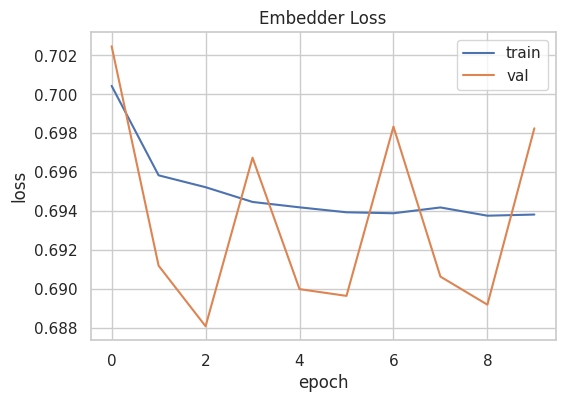

Embedding shapes: (321702, 64) (38052, 64) (38052, 64)

===== Hybrid: MLP-Embedder + XGBoost =====
AUC: 0.8107
AP : 0.2933
Precision: 0.2215
Recall   : 0.7469
F1-score : 0.3417


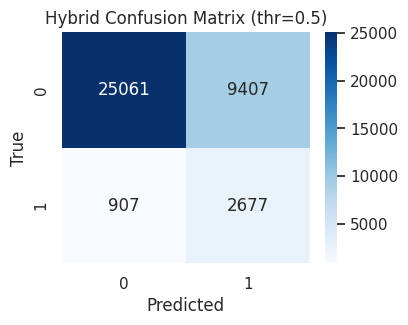

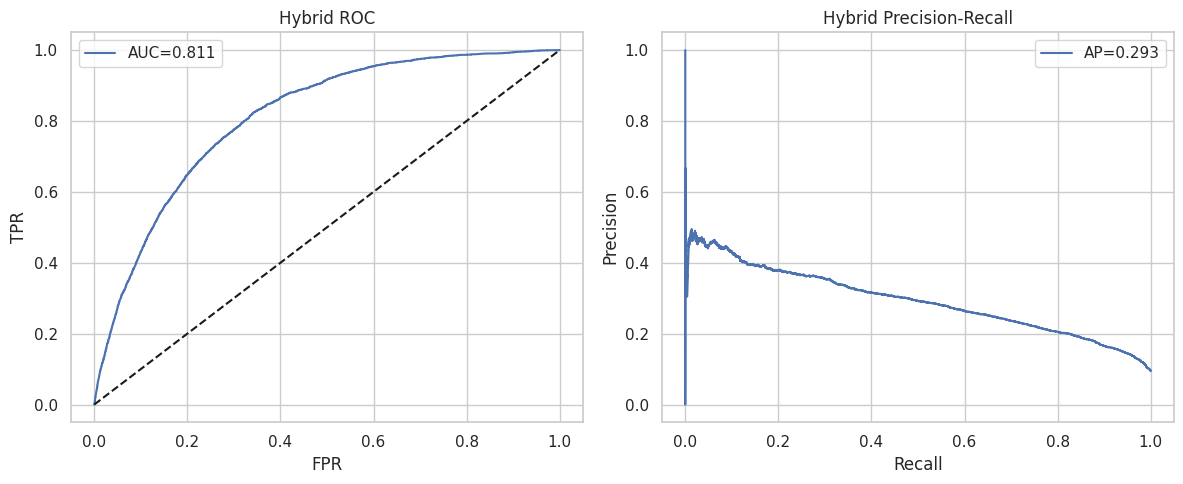

Saved hybrid models.


In [8]:
# ======================================================
# Hybrid Model: Neural Embeddings (MLP) + XGBoost
# ======================================================

# Install required packages (run once in Colab)
!pip install -q xgboost imbalanced-learn lightgbm

# --------------------
# Imports & settings
# --------------------
import os, random, warnings
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_score,
    recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve
)
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import xgboost as xgb

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --------------------
# 1) Load & Preprocess (full dataset)
# --------------------
DATA_PATH = "/content/heart_disease_health_indicators_BRFSS2015.csv"
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError("Upload the CSV to /content or change DATA_PATH")

df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)

# Feature groups (same as your pipeline)
binary_cols = ["HighBP","HighChol","CholCheck","Smoker","Stroke","Diabetes",
               "PhysActivity","Fruits","Veggies","HvyAlcoholConsump",
               "AnyHealthcare","NoDocbcCost","DiffWalk","Sex"]
numeric_cols = ["BMI","MentHlth","PhysHlth","Age"]
categorical_cols = ["GenHlth","Education","Income"]
FEAT_NAMES = binary_cols + numeric_cols + categorical_cols
TARGET = "HeartDiseaseorAttack"

X = df[FEAT_NAMES].copy()
y = df[TARGET].astype(int).copy()

# Preprocessing pipelines
num_transform = Pipeline([("imp", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
cat_transform = Pipeline([("imp", SimpleImputer(strategy="most_frequent"))])
preproc = ColumnTransformer([("num", num_transform, numeric_cols), ("cat", cat_transform, binary_cols+categorical_cols)])
preproc.fit(X)

X_all = preproc.transform(X)
if hasattr(X_all, "toarray"):
    X_all = X_all.toarray()

# Train/val/test split (70/15/15) with stratify
X_train_raw, X_temp, y_train, y_temp = train_test_split(X_all, y, test_size=0.30, stratify=y, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED)

# Balance training set with SMOTE
sm = SMOTE(random_state=SEED)
X_train_res, y_train_res = sm.fit_resample(X_train_raw, y_train)
print("Shapes (train_res, val, test):", X_train_res.shape, X_val.shape, X_test.shape)

# --------------------
# 2) Feature selection with LightGBM (top 15) — to keep embedding small & fast
# --------------------
lgb_fs = lgb.LGBMClassifier(random_state=SEED, n_jobs=-1)
lgb_fs.fit(X_train_res, y_train_res)
feat_imp = pd.Series(lgb_fs.feature_importances_, index=FEAT_NAMES).sort_values(ascending=False)
top_k = 15
top_feats = feat_imp.head(top_k).index.tolist()
print("Top features (selected):", top_feats)

feat_idx = [FEAT_NAMES.index(f) for f in top_feats]
X_train_res = X_train_res[:, feat_idx]
X_val = X_val[:, feat_idx]
X_test = X_test[:, feat_idx]
print("After feature selection shapes:", X_train_res.shape)

# --------------------
# 3) Define PyTorch Embedder (MLP) and training utilities
# --------------------
class NumpyDataset(Dataset):
    def __init__(self, X_np, y_np):
        self.X = torch.tensor(X_np, dtype=torch.float32)
        self.y = torch.tensor(y_np.values if hasattr(y_np, "values") else y_np, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

class MLPEmbedder(nn.Module):
    def __init__(self, input_dim, embed_dim=64, hidden=128, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.BatchNorm1d(hidden),
            nn.Dropout(dropout),
            nn.Linear(hidden, embed_dim),
            nn.ReLU()
        )
    def forward(self, x):
        return self.net(x)   # returns embedding (batch, embed_dim)

def train_embedder(embedder, train_ds, val_ds, epochs=10, batch_size=256, lr=1e-3):
    embedder = embedder.to(device)
    opt = torch.optim.AdamW(embedder.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    best_state = None
    best_val_loss = float("inf")
    train_hist, val_hist = [], []

    for ep in range(epochs):
        embedder.train()
        running = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            emb = embedder(xb)            # (B, embed_dim)
            # small head for binary task to give gradient signal to embedder
            logits = torch.nn.Linear(emb.shape[1], 1).to(device)(emb)  # ephemeral head
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()
            running += float(loss.item())
        train_loss = running / len(train_loader)
        # validation
        embedder.eval()
        vloss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                emb = embedder(xb)
                logits = torch.nn.Linear(emb.shape[1], 1).to(device)(emb)
                l = loss_fn(logits, yb)
                vloss += float(l.item())
        vloss /= len(val_loader)
        train_hist.append(train_loss); val_hist.append(vloss)
        print(f"Epoch {ep+1}/{epochs} — train_loss={train_loss:.4f} val_loss={vloss:.4f}")
        # save best
        if vloss < best_val_loss:
            best_val_loss = vloss
            best_state = {k:v.cpu() for k,v in embedder.state_dict().items()}

    if best_state is not None:
        embedder.load_state_dict(best_state)
    # plot losses
    plt.figure(figsize=(6,4)); plt.plot(train_hist, label="train"); plt.plot(val_hist, label="val")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Embedder Loss"); plt.legend(); plt.show()
    return embedder

# Create datasets
train_ds = NumpyDataset(X_train_res, y_train_res)
val_ds   = NumpyDataset(X_val, y_val)
test_ds  = NumpyDataset(X_test, y_test)

# Instantiate embedder and train (small model for speed; increase epochs for final)
input_dim = X_train_res.shape[1]
embed_dim = 64
embedder = MLPEmbedder(input_dim=input_dim, embed_dim=embed_dim, hidden=128, dropout=0.2)
embedder = train_embedder(embedder, train_ds, val_ds, epochs=10, batch_size=512, lr=1e-3)

# --------------------
# 4) Extract embeddings (train/val/test)
# --------------------
def extract_embeddings(embedder, X_np, batch_size=1024):
    embedder.eval()
    ds = NumpyDataset(X_np, np.zeros(len(X_np)))  # dummy labels
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
    embs = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device)
            e = embedder(xb).cpu().numpy()
            embs.append(e)
    return np.vstack(embs)

X_train_emb = extract_embeddings(embedder, X_train_res)
X_val_emb   = extract_embeddings(embedder, X_val)
X_test_emb  = extract_embeddings(embedder, X_test)
print("Embedding shapes:", X_train_emb.shape, X_val_emb.shape, X_test_emb.shape)

# --------------------
# 5) Train XGBoost on embeddings
# --------------------
xgb_clf = xgb.XGBClassifier(objective="binary:logistic", random_state=SEED, n_jobs=-1, use_label_encoder=False, eval_metric="logloss")
xgb_clf.fit(X_train_emb, y_train_res)

probs_xgb_emb = xgb_clf.predict_proba(X_test_emb)[:,1]
preds_xgb_emb = (probs_xgb_emb >= 0.5).astype(int)

# --------------------
# 6) Evaluation
# --------------------
auc = roc_auc_score(y_test, probs_xgb_emb)
ap  = average_precision_score(y_test, probs_xgb_emb)
prec = precision_score(y_test, preds_xgb_emb, zero_division=0)
rec  = recall_score(y_test, preds_xgb_emb, zero_division=0)
f1   = f1_score(y_test, preds_xgb_emb, zero_division=0)

print("\n===== Hybrid: MLP-Embedder + XGBoost =====")
print(f"AUC: {auc:.4f}")
print(f"AP : {ap:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, preds_xgb_emb)
plt.figure(figsize=(4,3)); sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Hybrid Confusion Matrix (thr=0.5)"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

# ROC & PR plots
fpr, tpr, _ = roc_curve(y_test, probs_xgb_emb)
prec_curve, rec_curve, _ = precision_recall_curve(y_test, probs_xgb_emb)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}"); plt.plot([0,1],[0,1],'k--')
plt.title("Hybrid ROC"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
plt.subplot(1,2,2)
plt.plot(rec_curve, prec_curve, label=f"AP={ap:.3f}")
plt.title("Hybrid Precision-Recall"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
plt.tight_layout(); plt.show()

# --------------------
# 7) (Optional) Save models
# --------------------
import joblib
joblib.dump(xgb_clf, "hybrid_xgb_on_emb.pkl")
torch.save(embedder.state_dict(), "mlp_embedder.pt")
print("Saved hybrid models.")
